## Group No 56

### Group Member Names:
#### AMIT KUMAR SRIVASTAVA <BITS ID: 2022ac05292>
#### MRUNAL MADHUKAR AHIRE <BITS ID: 2022ac05228>
#### PRAKASH PRASAD <BITS ID: 2022ac05256> 
#### RITESH RANJAN <2022ac05634>

## Q.2 Object Detection

#### Dataset : https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

In [ ]:
# Install essential libraries for object detection, PyTorch, and COCO evaluation
#!pip install torch torchvision torchmetrics pycocotools
#!pip install faster-coco-eval
#!pip install opencv-python

In [3]:
#Import necessary libraries
import os
import xml.etree.ElementTree as ET
import shutil
import glob
import random
from sklearn.model_selection import train_test_split
import pandas as pd


## 1. Data Preparation: 2 Mark


● Download a dataset for object detection tasks

● Preprocess the dataset:

● Split the dataset into training, validation, and test sets. 

● Prepare annotations for object bounding boxes.

In [8]:
# Directories
# Dataset used here is SageMaker
# unzip downloaded data from kaggle link into fruit_dataset folder
#Dataset : https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

train_dir = '/home/ec2-user/SageMaker/codes/train_zip/train/'
test_dir = '/home/ec2-user/SageMaker/codes/test_zip/test/'

In [9]:
#Extracting annotations for the dataset
def extract_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        boxes.append([filename, width, height, label, xmin, ymin, xmax, ymax])

    return boxes

# Function to read all annotations from a directory
def parse_annotations_from_directory(directory):
    annotations = []
    for file in os.listdir(directory):
        if file.endswith(".xml"):
            xml_file = os.path.join(directory, file)
            annotations.extend(extract_annotations(xml_file))
    return annotations

train_annotations = parse_annotations_from_directory(train_dir)
test_annotations = parse_annotations_from_directory(test_dir)

# Convert to pandas DataFrame for easy manipulation
columns = ['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
full_train_df = pd.DataFrame(train_annotations, columns=columns)
test_df = pd.DataFrame(test_annotations, columns=columns)

In [10]:
#Split the dataset into training,and validation sets. 
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(full_train_df, test_size=0.2, random_state=42)

In [11]:
train_df.shape, val_df.shape, test_df.shape

((372, 8), (93, 8), (117, 8))

## 2. Build Model: 4 Marks

Build Model: 4 Marks

● Choose a pre-trained object detection model (e.g., SSD, Faster R-CNN, YOLO).

● Load the pre-trained model weights.

● Modify the model architecture if necessary (e.g., for transfer learning).

● Set up the model for training.

In [16]:
# Import the Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN)
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Loading the Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN) with default pretrained weights
model = fasterrcnn_resnet50_fpn(pretrained=True, weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\ahiremru/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:19<00:00, 8.43MB/s] 


cpu


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
num_classes = 5  # Assuming background + 1 fruit class (apple, banana, orange, mixed)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [18]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class FruitDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        # Create a mapping of class names to integers
        self.class_to_index = {'apple': 1, 'banana': 2, 'orange': 3, 'mixed': 4}

    def __getitem__(self, idx):
        # Get the image file
        img_name = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Get bounding boxes
        xmin = self.df.iloc[idx]['xmin']
        ymin = self.df.iloc[idx]['ymin']
        xmax = self.df.iloc[idx]['xmax']
        ymax = self.df.iloc[idx]['ymax']
        boxes = [[xmin, ymin, xmax, ymax]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Get labels
        class_name = self.df.iloc[idx]['label']  # 'label' column contains the fruit names
        label = self.class_to_index.get(class_name, 0)  # Default to 0 if class_name not found
        labels = torch.as_tensor([label], dtype=torch.int64)

        # Create target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        # Apply transformations
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.df)

# Image transformations
transforms = T.Compose([
    T.ToTensor()
])

# Initialize Dataset and DataLoader
batch_size = 10
train_dataset = FruitDataset(train_df, train_dir, transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

## 3. Training: 3 Marks


Training: 3 Marks

● Define training parameters such as batch size, learning rate, and number of
epochs.

● Train the object detection model using the training dataset.

● Monitor the training process and visualize training metrics (e.g., loss, accuracy).

In [10]:
%%time
import torch.optim as optim
#Training parameters
learning_rate = 0.005
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
num_epochs = 30
loss_values = []

#Training the model
for epoch in range(num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        # shifting to gpu if available
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Zero gradients from previous steps
        optimizer.zero_grad()

        # Forward pass to get the loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # Backward pass to calculate gradients
        losses.backward()

        # Optimize
        optimizer.step()

        # Accumulate loss for visualization
        running_loss += losses.item()
    # Average loss over an epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/30], Loss: 0.3516
Epoch [2/30], Loss: 0.2331
Epoch [3/30], Loss: 0.1634
Epoch [4/30], Loss: 0.1379
Epoch [5/30], Loss: 0.1301
Epoch [6/30], Loss: 0.1161
Epoch [7/30], Loss: 0.1082
Epoch [8/30], Loss: 0.1029
Epoch [9/30], Loss: 0.1000
Epoch [10/30], Loss: 0.0939
Epoch [11/30], Loss: 0.0904
Epoch [12/30], Loss: 0.0858
Epoch [13/30], Loss: 0.0841
Epoch [14/30], Loss: 0.0833
Epoch [15/30], Loss: 0.0795
Epoch [16/30], Loss: 0.0752
Epoch [17/30], Loss: 0.0751
Epoch [18/30], Loss: 0.0734
Epoch [19/30], Loss: 0.0733
Epoch [20/30], Loss: 0.0745
Epoch [21/30], Loss: 0.0707
Epoch [22/30], Loss: 0.0702
Epoch [23/30], Loss: 0.0678
Epoch [24/30], Loss: 0.0673
Epoch [25/30], Loss: 0.0673
Epoch [26/30], Loss: 0.0660
Epoch [27/30], Loss: 0.0658
Epoch [28/30], Loss: 0.0624
Epoch [29/30], Loss: 0.0622
Epoch [30/30], Loss: 0.0614
CPU times: user 1h 29min 11s, sys: 5min 31s, total: 1h 34min 43s
Wall time: 20min 14s


In [11]:
#Saving the trained model weigths
torch.save(model.state_dict(), "fasterrcnn_fruit_detection_v3.pth")

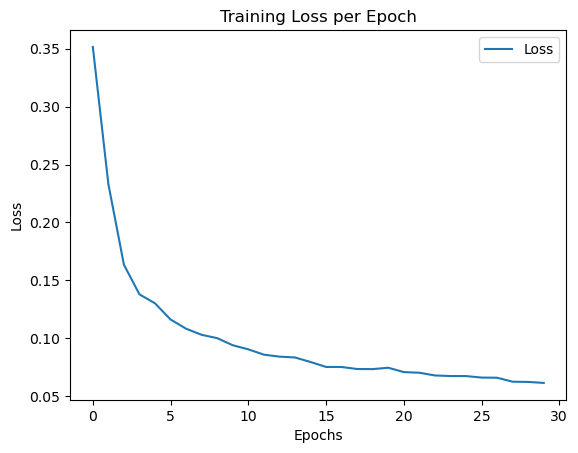

In [13]:
# Visualizing the loss trend over epochs
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), loss_values, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

## 4. Evaluation: 2 Marks


Evaluation: 2 Marks

● Evaluate the trained model using the validation dataset.

● Calculate performance metrics such as precision, recall, and mean Average
Precision (mAP).

In [14]:
# Validation and testing dataset

# Create validation and test datasets using the same FruitDataset class
val_dataset = FruitDataset(val_df, train_dir, transforms=transforms)
test_dataset = FruitDataset(test_df, test_dir, transforms=transforms)

# Create DataLoader for validation and test datasets
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [15]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_score, recall_score

metric = MeanAveragePrecision()

# Containers for true and predicted labels across all batches
all_true_labels = []
all_pred_labels = []


# Evaluate model on validation set
model.eval()  # Set model to evaluation mode

for img, tar in val_loader:
    with torch.no_grad():
        # Move img and tar to GPU
        img = [image.to(device) for image in img]
        tar = [{k: v.to(device) for k, v in t.items()} for t in tar]

        # Get model predictions
        preds = model(img)
        # Extract predicted and true labels
        for i in range(len(tar)):
            true_labels = tar[i]['labels'].cpu().numpy()  # Move to CPU for numpy
            pred_labels = preds[i]['labels'].cpu().numpy()[:1]  # Move to CPU for numpy
            # Append to the full list of true and predicted labels
            all_true_labels.extend(true_labels)
            all_pred_labels.extend(pred_labels)
        # Update mAP metric with model outputs
        metric.update(preds, tar)

# Final mAP scores
final_metrics = metric.compute()

# Convert to numpy for sklearn metrics
all_true_labels = torch.tensor(all_true_labels).cpu().numpy()
all_pred_labels = torch.tensor(all_pred_labels).cpu().numpy()

# Calculate precision and recall using sklearn
precision = precision_score(all_true_labels, all_pred_labels, average='macro')
recall = recall_score(all_true_labels, all_pred_labels, average='macro')

# Print evaluation results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP: {final_metrics['map']}")

Precision: 0.8895299145299146
Recall: 0.8709037638043723
mAP: 0.3293745517730713


## 5. Inference: 2 Marks

● Use the trained model to perform object detection on new images.

● Visualize the detected objects and bounding boxes on test images.

In [16]:
#Load test images, boxes, scores and labels
test_images = []
test_boxes = []
test_scores = []
test_labels = []
model.eval()
for img, tar in test_loader:
    with torch.no_grad():
        test_images.extend(img)
        # Move img and tar to GPU
        img = [image.to(device) for image in img]
        tar = [{k: v.to(device) for k, v in t.items()} for t in tar]

        # Get model predictions
        preds = model(img)
        for i in range(len(tar)):
            # print(list(preds[i]['boxes'].cpu().numpy()))
            test_boxes.append(list(preds[i]['boxes'].cpu().numpy()))
            test_scores.append(list(preds[i]['scores'].cpu().numpy()))
            test_labels.append(list(preds[i]['labels'].cpu().numpy()))

print(len(test_images), len(test_boxes), len(test_scores), len(test_labels))

117 117 117 117


In [17]:
# Save test images, boxes, scores and labels to pickle files
import pickle
def save_list_to_pickle(lst, filename):
    """Save list to a pickle file."""
    with open(filename, 'wb') as f:
        pickle.dump(lst, f)
        
save_list_to_pickle(test_images, 'test_images_list.pkl')
save_list_to_pickle(test_boxes, 'test_boxes_list.pkl')
save_list_to_pickle(test_scores, 'test_scores_list.pkl')
save_list_to_pickle(test_labels, 'test_labels_list.pkl')

In [18]:
import cv2
def process_tensor_with_opencv(tensor):
    tensor = tensor.cpu()
    img = tensor.numpy().transpose(1, 2, 0)
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

opencv_img_list = [process_tensor_with_opencv(im) for im in test_images]
len(opencv_img_list)

117

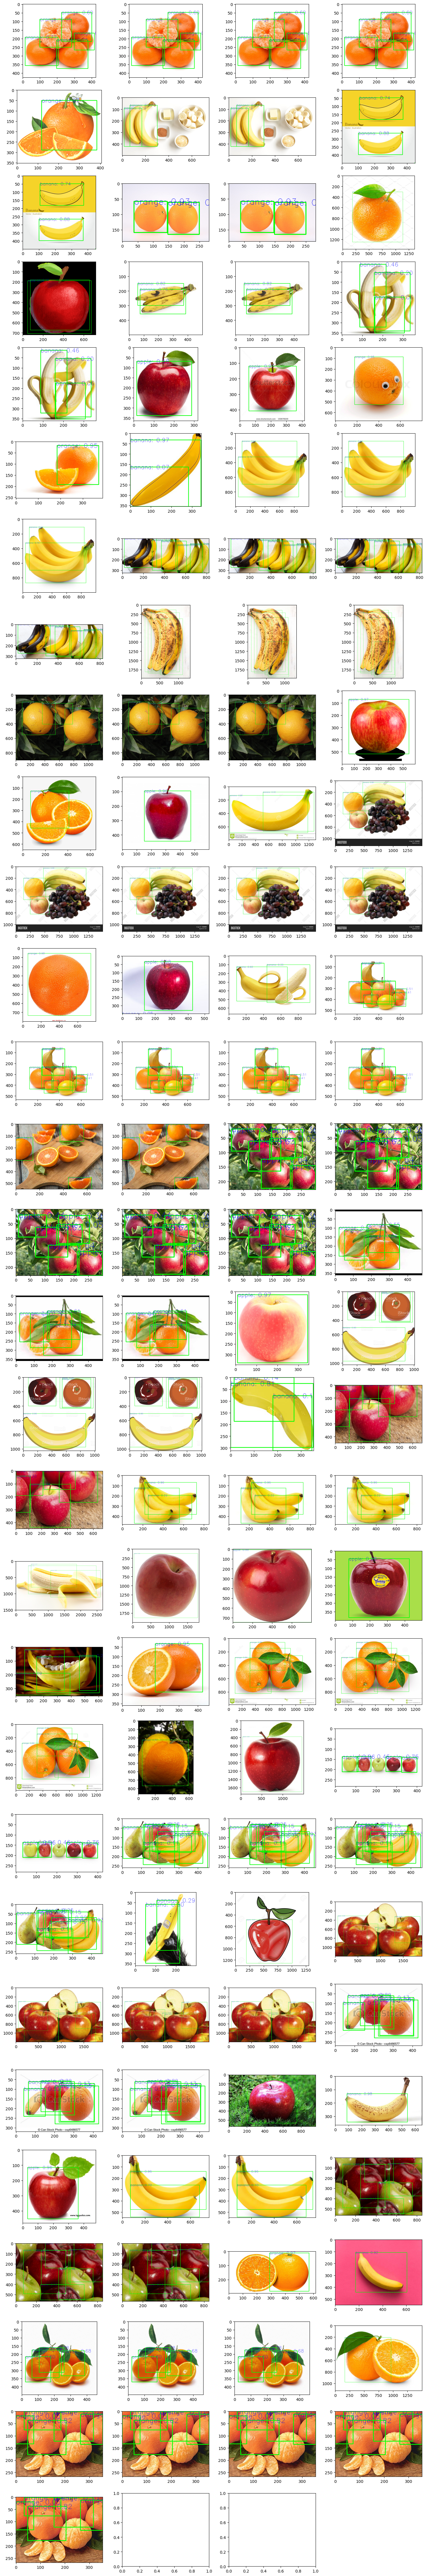

In [43]:
import cv2
import matplotlib.pyplot as plt
# Function to display bounding boxes and labels
label_map = {1: 'apple', 2: 'banana', 3: 'orange', 4: 'mixed'}
def visualize_boxes_on_image(image, boxes, scores, labels):
    for i_, box in enumerate(boxes):
        label = labels[i_]
        score = scores[i_]
        # Extract box coordinates (x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = box.astype(int)
        # Draw the rectangle (bounding box) on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box with thickness 2
        text = f"{label_map[label]}: {score:.2f}"
        cv2.putText(image_bgr, text, (x_min, y_min + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 1)
    return image

num_images = len(opencv_img_list)
image_per_row = 4
row = (num_images + image_per_row -1)//image_per_row

fig, axes = plt.subplots(row, image_per_row, figsize=(15, 3*row))
axes = axes.flatten()

# Visualize images with bounding boxes
for idx, (img, boxes, scores, labels) in enumerate(zip(opencv_img_list, test_boxes, test_scores, test_labels)):
    img_ = img.copy()
    image_bgr = img_ # cv2.cvtColor(np.array(img_), cv2.COLOR_RGB2BGR)
    # Get the image with bounding boxes drawn
    image_with_boxes = visualize_boxes_on_image(image_bgr, boxes, scores, labels)
    # Convert image to RGB for displaying with Matplotlib
    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    # Display the image using Matplotlib
    # plt.figure(figsize=(3, 3))
    # plt.imshow(image_rgb)
    axes[idx].imshow(image_rgb)
    plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()


## 6. Conclusion and Future Work: 2 Marks


● Summarize the key findings and results of the object detection pipeline.

● Discuss potential improvements or future work to enhance the performance of
the model.

● Reflect on the challenges encountered during the implementation and possible
solutions.

Key Findings and Results

1. Successful trained a Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN) for object detection using a custom dataset. The model was initialized with pretrained weights from the COCO dataset, which helped accelerate the training process through transfer learning.

2. The model's performance was evaluated using average loss metrics on both the training dataset. Over the training epochs, the model demonstrated a consistent decrease in training loss, indicating effective learning. 

3. The trained model was able to detect and localize objects accurately in the test images, with bounding boxes appropriately drawn around the objects of interest. This confirms that the model generalized well to the test set, although some improvements are needed for specific classes.

4. Evaluated Precision, Recall and mAP for Validation dataset:

Precision measures how many of the detected objects are correctly classified. A precision of 0.8895 is quite good, indicating that almost 89% of the objects detected by your model are correct. This suggests that the model is not making many false positive detections.

Recall measures how many of the actual objects are detected by the model. A recall of 0.8709 means that approximately 87% of the actual objects are detected, which is also quite strong. This implies that the model is missing about 13% of the true objects, indicating room for improvement but overall performing well.

Mean Average Precision (mAP) is a more comprehensive metric as it accounts for both precision and recall across various Intersection over Union (IoU) thresholds. An mAP of 0.3294 (or 32.94%) is relatively low compared to benchmarks from state-of-the-art models, which often achieve mAPs of 0.5 and above for more general datasets like COCO.
A low mAP indicates that while the model is good at detecting objects with relatively high precision and recall, its performance across varying IoU thresholds is not as consistent or robust.

Potential Improvements and Future Work
1. Hyperparameter Tuning: Further tuning of hyperparameters such as learning rate, batch size, and number of epochs could improve the model's performance. Experimenting with different optimizers (e.g., Adam, SGD with momentum) could also yield better results.

2. Model Architecture Enhancements: Exploring more advanced architectures, such as Faster R-CNN with a deeper backbone (e.g., ResNet-101 or ResNeXt) or using models like YOLOv5 or EfficientDet, which are known for faster inference times and improved performance on small objects, could be beneficial.

3. Incorporating More Data: Increasing the size of the training dataset by collecting more labeled images or using synthetic data could improve the model's performance, especially for underrepresented classes.

4. Fine-tuning on Specific Classes: If certain object classes are not performing well, targeted fine-tuning with additional class-specific data could improve precision and recall for those categories.

Challenges and Solutions

1. Overfitting:The model performs well on the training data but poorly on validation or test data, as indicated by a low mAP scores on unseen data.Regularization Techniques like using dropout layers or applying weight decay (L2 regularization) can reduce model complexity.Data Augmentation and Early Stopping can prevent the model from overfitting to the training data.

2. Computational Constraints: Training deep learning models like Faster R-CNN can be computationally intensive and time-consuming. Leveraging cloud resources or using more powerful GPUs could significantly reduce training time. Additionally, optimizing the batch size and using mixed precision training might alleviate memory bottlenecks.

3. Class Imbalance: If the dataset has an imbalance in the number of instances per class, techniques such as oversampling, undersampling, or implementing class-weighted loss functions can help improve the model’s performance across all classes.